In [1]:
!pip install -q numerapi pandas pyarrow matplotlib scikit-learn cloudpickle seaborn scipy xgboost lightgbm
!pip -q uninstall tensorflow keras
!pip -q install tensorflow==2.15.0 scikeras catboost
!pip install -q --no-deps numerai-tools

Proceed (Y/n)? Y
Proceed (Y/n)? Y
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 85.9 MB/s eta 0:00:00


In [2]:
from numerapi import NumerAPI
import pickle
import pandas as pd
import json

napi = NumerAPI()
DATA_VERSION = "v4.3"

napi.download_dataset(f"{DATA_VERSION}/features.json")
napi.download_dataset(f"{DATA_VERSION}/train_int8.parquet")
napi.download_dataset(f"{DATA_VERSION}/live_int8.parquet")
napi.download_dataset(f"{DATA_VERSION}/validation_int8.parquet")
napi.download_dataset(f"{DATA_VERSION}/meta_model.parquet")

# feature_metadata = json.load(open(f"{DATA_VERSION}/features.json"))
# feature_set = feature_metadata['feature_sets']['medium']

# custom set of features by SHATTEREDX, https://forum.numer.ai/t/shatteredxs-improved-compact-feature-set-225-features-for-v4-3-midnight-data/6982
with open('shatFeatsv43.pkl', 'rb') as file:
    feature_set = pickle.load(file)

train = pd.read_parquet(f"{DATA_VERSION}/train_int8.parquet", columns = ["era", "target"] + feature_set)
train = train[train["era"].isin(train["era"].unique()[::4])]  # downsampling to every 4th era to avoid overlaps and save memory during training

validation_set = pd.read_parquet(f"{DATA_VERSION}/validation_int8.parquet", columns = ["era", "data_type", "target"] + feature_set)
validation_set = validation_set[validation_set["data_type"] == "validation"]
validation_set = validation_set[validation_set["era"].isin(validation_set["era"].unique()[::4])]

validation_set["meta_model"] = pd.read_parquet(f"{DATA_VERSION}/meta_model.parquet")["numerai_meta_model"]
del validation_set['data_type']

live_data = pd.read_parquet(f"{DATA_VERSION}/live_int8.parquet", columns = ["era", "target"] + feature_set)

v4.3/features.json: 1.12MB [00:01, 1.11MB/s]                           
v4.3/train_int8.parquet: 2.10GB [02:28, 14.1MB/s]                            
v4.3/live_int8.parquet: 6.64MB [00:01, 4.75MB/s]                            
v4.3/validation_int8.parquet: 2.59GB [02:29, 17.3MB/s]                            
v4.3/meta_model.parquet: 27.9MB [00:02, 9.64MB/s]                            


In [3]:
# state-of-the-art tree-based regressors comparison:

# 1. XGBRegressor (GridSearchCV over n_estimators, max_depth, colsample_bytree and learning_rate)
# 2. LightGBMRegressor (Numerai example model, alternatively: https://forum.numer.ai/t/super-massive-lgbm-grid-search/6463)
# 3. CatBoostRegressor (GridSearchCV over n_estimators and learning_rate)
# 4. GradientBoostingRegressor (for large datasets HistGradientBoostingRegressor might be faster alternative)

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

xgb = XGBRegressor(n_estimators = 1000,
                   colsample_bytree = 0.1,
                   learning_rate = 0.01,
                   max_depth = 5)

lgbm = LGBMRegressor(n_estimators = 2000,
                     max_depth = 5,
                     learning_rate = 0.01,
                     colsample_bytree = 0.1,
                     num_leaves = 2**5-1)

cat = CatBoostRegressor(learning_rate = 0.5,
                        n_estimators = 500,
                        verbose = 0)

gbr = GradientBoostingRegressor(max_depth = 5,
                                learning_rate = 0.01,
                                subsample = 0.5,
                                n_estimators = 10)

# in addition, let's see how simple neural network with 3 hidden layers and LeakyReLU activation function compares
# to those models; feed-forward architecture is not recommended for time-series data but we can easily wrap this inside
# KerasRegressor; LSTM's are preferred

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, BatchNormalization, Input
from scikeras.wrappers import KerasRegressor

def build_model(input_dim):
    model = Sequential([Input(shape = (input_dim, )),
                        Dense(2048),
                        LeakyReLU(alpha = 0.05),
                        Dropout(0.3),
                        BatchNormalization(),
                        Dense(1024),
                        LeakyReLU(alpha = 0.05),
                        Dropout(0.2),
                        BatchNormalization(),
                        Dense(256),
                        LeakyReLU(alpha = 0.05),
                        Dense(1, activation = 'linear')])
    model.compile(optimizer = 'adam', loss = 'mse')
    return model

# another, less conventional option is to use sigmoid output activation function + binary cross entropy loss
# * or 'mae' instead of 'mse' for neural network to be less sensitive to outliers
# depending whether you treat it as regression or classification task

nn = KerasRegressor(build_fn = lambda: build_model(len(feature_set)),
                    epochs = 50,
                    batch_size = 64)

nn2 = KerasRegressor(build_fn = lambda: build_model(len(feature_set)),
                     epochs = 50,
                     batch_size = 128) # only batch size differs, to be adjusted

In [ ]:
""" example code for time-series cross-validation (might require Colab Pro to run)

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

model = XGBRegressor()
tscv = TimeSeriesSplit(n_splits = 5)
param_grid = {'n_estimators': [500, 1000, 2000, 3000],
              'colsample_bytree': [0.01, 0.02, 0.03],
              'max_depth': [5, 6, 7]}

gridsearch = GridSearchCV(estimator = model,
                          param_grid = param_grid,
                          cv = tscv,
                          n_jobs = -1,
                          scoring = 'neg_mean_squared_error')

gridsearch.fit(train[feature_set], train['target'])
model = gridsearch.best_estimator_

"""

In [9]:
cat.fit(train[feature_set], train['target'])
xgb.fit(train[feature_set], train['target'])
lgbm.fit(train[feature_set], train['target'])
gbr.fit(train[feature_set], train['target'])

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.398229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1125
[LightGBM] [Info] Number of data points in the train set: 606176, number of used features: 225
[LightGBM] [Info] Start training from score 0.499979
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


GradientBoostingRegressor(learning_rate=0.01, max_depth=5, n_estimators=10,
                          subsample=0.5)

In [20]:
nn.fit(train[feature_set], train['target'])

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
9472/9472 [==============================] - 41s 4ms/step - loss: 0.0642
Epoch 2/50
9472/9472 [==============================] - 38s 4ms/step - loss: 0.0504
Epoch 3/50
9472/9472 [==============================] - 37s 4ms/step - loss: 0.0500
Epoch 4/50
9472/9472 [==============================] - 39s 4ms/step - loss: 0.0498
Epoch 5/50
9472/9472 [==============================] - 40s 4ms/step - loss: 0.0498
Epoch 6/50
9472/9472 [==============================] - 38s 4ms/step - loss: 0.0498
Epoch 7/50
9472/9472 [==============================] - 37s 4ms/step - loss: 0.0498
Epoch 8/50
9472/9472 [==============================] - 37s 4ms/step - loss: 0.0498
Epoch 9/50
9472/9472 [==============================] - 37s 4ms/step - loss: 0.0498
Epoch 10/50
9472/9472 [==============================] - 37s 4ms/step - loss: 0.0498
Epoch 11/50
9472/9472 [==============================] - 37s 4ms/step - loss: 0.0498
Epoch 12/50
9472/9472 [==============================] - 37s 4ms/step - lo

KerasRegressor(
	model=None
	build_fn=<function <lambda> at 0x78d2a9e0b640>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=64
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=50
)

In [26]:
nn2.fit(train[feature_set], train['target'])

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
4736/4736 [==============================] - 21s 4ms/step - loss: 0.0807
Epoch 2/50
4736/4736 [==============================] - 19s 4ms/step - loss: 0.0507
Epoch 3/50
4736/4736 [==============================] - 19s 4ms/step - loss: 0.0502
Epoch 4/50
4736/4736 [==============================] - 19s 4ms/step - loss: 0.0501
Epoch 5/50
4736/4736 [==============================] - 19s 4ms/step - loss: 0.0499
Epoch 6/50
4736/4736 [==============================] - 19s 4ms/step - loss: 0.0498
Epoch 7/50
4736/4736 [==============================] - 19s 4ms/step - loss: 0.0498
Epoch 8/50
4736/4736 [==============================] - 19s 4ms/step - loss: 0.0497
Epoch 9/50
4736/4736 [==============================] - 19s 4ms/step - loss: 0.0497
Epoch 10/50
4736/4736 [==============================] - 20s 4ms/step - loss: 0.0497
Epoch 11/50
4736/4736 [==============================] - 19s 4ms/step - loss: 0.0497
Epoch 12/50
4736/4736 [==============================] - 19s 4ms/step - lo

KerasRegressor(
	model=None
	build_fn=<function <lambda> at 0x78d2a9b60f70>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=128
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=50
)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
4736/4736 [==============================] - 7s 1ms/step


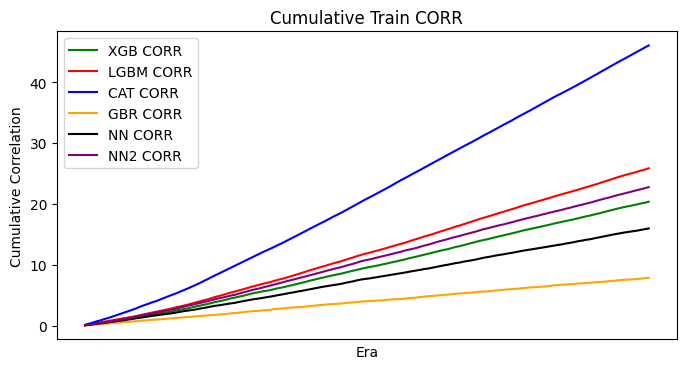

In [27]:
# let's calculate culminative CORR on test set

from numerai_tools.scoring import numerai_corr
import matplotlib.pyplot as plt

models = {"xgb": xgb, "lgbm": lgbm, "cat": cat, "gbr": gbr, "nn": nn, "nn2": nn2}
train_corr = {}

for key, value in models.items():
  train[key] = value.predict(train[feature_set])
  train_corr[key] = train.groupby("era").apply(
      lambda x: numerai_corr(x[[key]].dropna(), x["target"].dropna()))

plt.figure(figsize=(8, 4))

plt.plot(train_corr['xgb'].cumsum(), label = 'XGB CORR', color = 'green')
plt.plot(train_corr['lgbm'].cumsum(), label = 'LGBM CORR', color = 'red')
plt.plot(train_corr['cat'].cumsum(), label = 'CAT CORR', color = 'blue')
plt.plot(train_corr['gbr'].cumsum(), label = 'GBR CORR', color = 'orange')
plt.plot(train_corr['nn'].cumsum(), label = 'NN CORR', color = 'black')
plt.plot(train_corr['nn2'].cumsum(), label = 'NN2 CORR', color = 'purple')

plt.title('Cumulative Train CORR')
plt.xlabel('Era')
plt.ylabel('Cumulative Correlation')
plt.xticks([])
plt.legend()
plt.show()

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
5401/5401 [==============================] - 8s 1ms/step


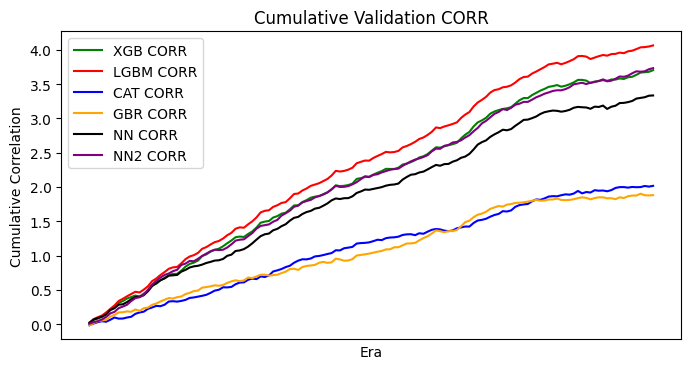

In [28]:
# due to the way Numerai data is organized, we delete first 4 eras to prevent data leakage
# and see how models perform on out-of-sample

last_train_era = int(train["era"].unique()[-1])
eras_to_embargo = [str(era).zfill(4) for era in [last_train_era + i for i in range(4)]]
validation_set = validation_set[~validation_set["era"].isin(eras_to_embargo)]

valid_corr = {}

for key, value in models.items():
  validation_set[key] = value.predict(validation_set[feature_set])
  valid_corr[key] = validation_set.groupby("era").apply(
      lambda x: numerai_corr(x[[key]].dropna(), x["target"].dropna()))

plt.figure(figsize=(8, 4))

plt.plot(valid_corr['xgb'].cumsum(), label = 'XGB CORR', color = 'green')
plt.plot(valid_corr['lgbm'].cumsum(), label = 'LGBM CORR', color = 'red')
plt.plot(valid_corr['cat'].cumsum(), label = 'CAT CORR', color = 'blue')
plt.plot(valid_corr['gbr'].cumsum(), label = 'GBR CORR', color = 'orange')
plt.plot(valid_corr['nn'].cumsum(), label = 'NN CORR', color = 'black')
plt.plot(valid_corr['nn2'].cumsum(), label = 'NN2 CORR', color = 'purple')


plt.title('Cumulative Validation CORR')
plt.xlabel('Era')
plt.ylabel('Cumulative Correlation')
plt.xticks([])
plt.legend()
plt.show()

In [29]:
# even though on training set CatBoostRegressor was performing well, on validation set is as bad as
# GradientBoostingRegressor, Neural Network trained on batch_size = 64 performs way worse than this trained on
# bigger batches
# let's calculate different metrics, from now on we drop CatBoostRegressor, GradientBoostingRegressor and NN

del models['cat'], models['gbr'], models['nn']
del train['cat'], train['gbr'], train['nn']
del validation_set['cat'], validation_set['gbr'], validation_set['nn']

In [30]:
# let's create an ensemble model

from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

ensemble = StackingRegressor(estimators = [('xgb', xgb), ('nn2', nn2), ('lgbm', lgbm)],
                             final_estimator = LinearRegression(),
                             passthrough = False, cv = 'prefit')

ensemble.fit(train[feature_set], train['target'])

4736/4736 [==============================] - 7s 1ms/step
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


StackingRegressor(cv='prefit',
                  estimators=[('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.1, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,...
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=1000, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                              ('nn2',
                               KerasRegressor(batch_size=128, build_fn=<function <lambda> at 0x78d2a9b60f70>, epochs=50)),
                              ('lgbm',
                               LGBMRegressor(colsample_bytree=0.1,
                                             learning_rate=0.01, max_depth=5,
                                             n_estimators=2000))],
                  final_estimator=LinearRegression())

5401/5401 [==============================] - 8s 1ms/step
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


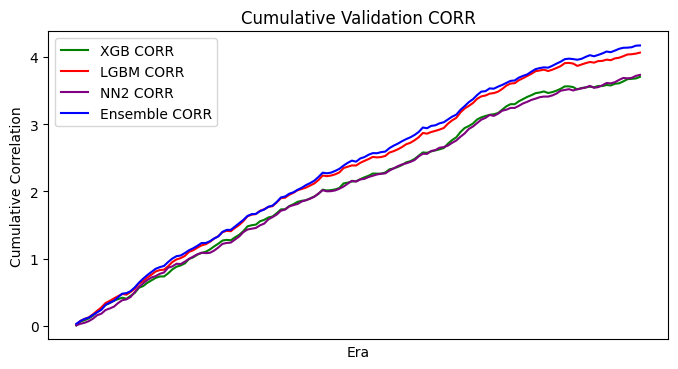

In [32]:
validation_set["ensemble"] = ensemble.predict(validation_set[feature_set])
ensemble_corr = validation_set.groupby("era").apply(
    lambda x: numerai_corr(x[["ensemble"]].dropna(), x["target"].dropna()))

plt.figure(figsize = (8, 4))

plt.plot(valid_corr['xgb'].cumsum(), label = 'XGB CORR', color = 'green')
plt.plot(valid_corr['lgbm'].cumsum(), label = 'LGBM CORR', color = 'red')
plt.plot(valid_corr['nn2'].cumsum(), label = 'NN2 CORR', color = 'purple')
plt.plot(ensemble_corr.cumsum(), label = 'Ensemble CORR', color = 'blue')

plt.title('Cumulative Validation CORR')
plt.xlabel('Era')
plt.ylabel('Cumulative Correlation')
plt.xticks([])
plt.legend()
plt.show()

In [49]:
# our ensemble model is outperforming all base estimators,
# let's calculate performance metrics and see how we can improve it

xgb_mean = valid_corr['xgb'].mean()
xgb_std = valid_corr['xgb'].std(ddof = 0)
xgb_sharpe = xgb_mean / xgb_std
xgb_max_drawdown = (valid_corr['xgb'].cumsum().expanding(min_periods = 1).max() - valid_corr['xgb'].cumsum()).max()

lgbm_mean = valid_corr['lgbm'].mean()
lgbm_std = valid_corr['lgbm'].std(ddof = 0)
lgbm_sharpe = lgbm_mean / lgbm_std
lgbm_max_drawdown = (valid_corr['lgbm'].cumsum().expanding(min_periods = 1).max() - valid_corr['lgbm'].cumsum()).max()

nn2_mean = valid_corr['nn2'].mean()
nn2_std = valid_corr['nn2'].std(ddof = 0)
nn2_sharpe = nn2_mean / nn2_std
nn2_max_drawdown = (valid_corr['nn2'].cumsum().expanding(min_periods = 1).max() - valid_corr['nn2'].cumsum()).max()

ensemble_mean = ensemble_corr.mean()
ensemble_std = ensemble_corr.std(ddof = 0)
ensemble_sharpe = ensemble_mean / ensemble_std
ensemble_max_drawdown = (ensemble_corr.cumsum().expanding(min_periods = 1).max() - ensemble_corr.cumsum()).max()

# Creating the DataFrame
pd.DataFrame({
    "mean": [ensemble_mean['ensemble'], xgb_mean['xgb'], lgbm_mean['lgbm'], nn2_mean['nn2']],
    "std": [ensemble_std['ensemble'], xgb_std['xgb'], lgbm_std['lgbm'], nn2_std['nn2']],
    "sharpe": [ensemble_sharpe['ensemble'], xgb_sharpe['xgb'], lgbm_sharpe['lgbm'], nn2_sharpe['nn2']],
    "max_drawdown": [ensemble_max_drawdown['ensemble'], xgb_max_drawdown['xgb'], lgbm_max_drawdown['lgbm'], nn2_max_drawdown['nn2']]
}, index=["ensemble", "xgb", "lgbm", "nn2"]).T


,ensemble,xgb,lgbm,nn2
mean,0.030678,0.027240,0.029893,0.027458
std,0.019565,0.020915,0.020963,0.019347
sharpe,1.568041,1.302434,1.426019,1.419255
max_drawdown,0.016058,0.046681,0.044791,0.028720


<Axes: title={'center': 'Max Feature Exposures'}, xlabel='era'>

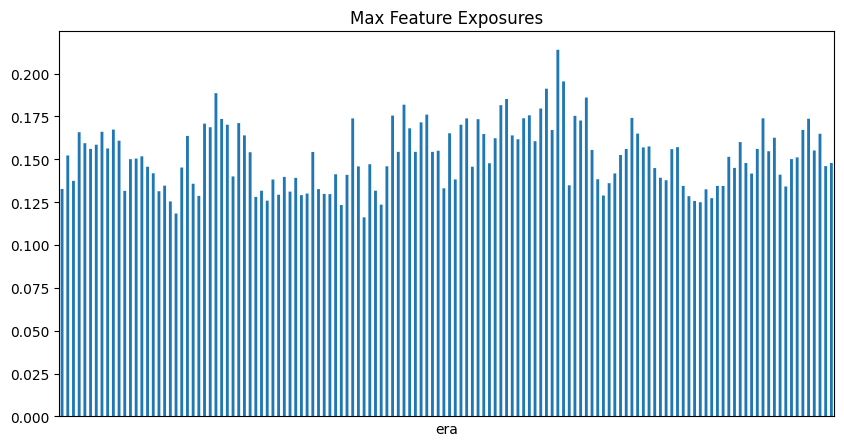

In [50]:
# ensemble model has the highest sharpe ratio and significantly lower max_drawdown
# we can try to improve sharpe even more by applyting feature neutralization
# the idea behind feature neutralization: https://forum.numer.ai/t/model-diagnostics-feature-exposure/899

feature_exposures = validation_set.groupby("era").apply(
    lambda x: x[feature_set].corrwith(x["ensemble"]))

max_feature_exposure = feature_exposures.max(axis=1)

max_feature_exposure.plot(
    title = "Max Feature Exposures",
    kind = "bar",
    figsize = (10, 5),
    xticks = [],
    snap = False)

<Axes: title={'center': 'Cumulative Correlation of Neutralized Predictions'}, xlabel='era'>

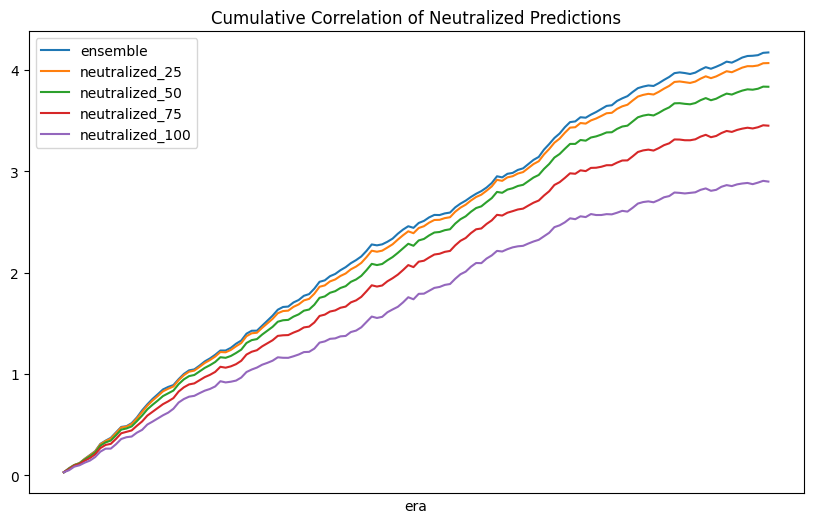

In [53]:
from numerai_tools.scoring import neutralize

proportions = [0.25, 0.5, 0.75, 1.0]

for proportion in proportions:
    neutralized = validation_set.groupby("era", group_keys = True).apply(
        lambda d: neutralize(d[["ensemble"]], d[feature_set], proportion = proportion)).reset_index().set_index("id")

    validation_set[f"neutralized_{proportion*100:.0f}"] = neutralized["ensemble"]

prediction_cols = ["ensemble"] + [f for f in validation_set.columns if "neutralized" in f]
validation_set[["era", "target"] + prediction_cols]

correlations = validation_set.groupby("era").apply(
    lambda x: numerai_corr(x[prediction_cols], x["target"]))

cumulative_correlations = correlations.cumsum().sort_index()

pd.DataFrame(cumulative_correlations).plot(
    title = "Cumulative Correlation of Neutralized Predictions",
    figsize = (10, 6),
    xticks = [])

In [56]:
# neutralization over all features decreases culminative correlation, this might be caused by the
# fact that neural networks have difficulties learning irregular patterns, therefore might be sensitive to
# information loss caused by feature neutralization, see: https://arxiv.org/pdf/2207.08815

# we can upload our model:

import cloudpickle

def predict(live_data: pd.DataFrame) -> pd.DataFrame:
    live_predictions = ensemble.predict(live_data[feature_set])
    submission = pd.Series(live_predictions, index = live_data.index)
    return submission.to_frame("prediction")

p = cloudpickle.dumps(predict)
with open("predict.pkl", "wb") as f:
    f.write(p)

try:
    from google.colab import files
    files.download('predict.pkl')
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>